# <center><u> Final LSTM/GRU Layout - Adri and Elian

# Define Inputs

In [1]:
household = 20
model_name = 'house20_function_tests'
n_input = 144
n_features = 5 
n_output = 72
n_split = 2 * 24 * 324


# Get Household Data

In [2]:
#Import Libraries and Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv
load_dotenv()

def get_household_data(household):
    #Access Credentials
    db_host = os.getenv("DB_HOST")
    db_name = os.getenv("DB_NAME")
    db_user = os.getenv("DB_USER")
    db_password = os.getenv("DB_PASSWORD")
    db_port = os.getenv("DB_PORT")

    conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
    )

    query=f"""
    select * 
    from agg.tidy_data_final
    where site = {household}
    """

    df = pd.read_sql_query(query, conn)
    df = df.set_index('timestamp', drop=False)
    df = df.sort_index()

    return df
    

# Prepare Data Set for LSTM/GRU Models

In [11]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

def data_prep(df):
    global n_input 
    global n_features
    global n_output
    global n_split

    # Select features of use for later on
    df_input = df[['net_load', 'precipitation_probability',
                'solar_radiation','sunshine_duration','weekend_or_bank_holiday', 
                    'month', 'day', 'hour', 'day_of_week', 'season', 
                    'avg_net_load',]]
    
    
    variables = ['net_load','solar_radiation','sunshine_duration', 'precipitation_probability', 'avg_net_load' ]


    for var in variables:
        new_var_name = var + '_norm'
        df_input[new_var_name] = scaler.fit_transform(df_input[[var]])

    df_input['sunshine_duration_norm(t+48)'] = df_input['sunshine_duration_norm'].shift(-48) #Add prediction for time the day after
    df_input['solar_radiation_norm(t+48)'] = df_input['solar_radiation_norm'].shift(-48) #Add prediction for time the day after
    df_input['precipitation_probability_norm(t+48)'] = df_input['precipitation_probability_norm'].shift(-48) #Add prediction for time the day after

    df_input.dropna(inplace=True)

    # df_input = df_input[['net_load_norm', 'avg_net_load_norm', 'weekend_or_bank_holiday', 'sunshine_duration_norm(t+48)',
    #            'solar_radiation_norm(t+48)','precipitation_probability_norm(t+48)',
    #            'month', 'day', 'hour', 'day_of_week', 'season', 
    #                 ]]
    
    df_input = df_input[['net_load_norm', 'weekend_or_bank_holiday', 'sunshine_duration_norm(t+48)',
            'solar_radiation_norm(t+48)','precipitation_probability_norm(t+48)'
                ]]

    X, y = [], []
    for i in range(len(df_input) - n_input - n_output + 1):
        # Select all columns for the input sequence
        X.append(df_input.iloc[i:(i + n_input)].values)  
        
        y.append(df_input['net_load_norm'].iloc[(i + n_input):(i + n_input + n_output)].values)

    X = np.array(X).reshape((len(X), n_input, -1))  
    y = np.array(y)

    X_train = X[:n_split]
    y_train = y[:n_split]

    X_test = X[n_split:]
    y_test = y[n_split:]

    return X_train, y_train, X_test, y_test, df_input

# Build and Fit LSTM/ GRU Models

In [4]:
# Import all Necessary Keras Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def build_model(X_train, y_train, model_name):
    model = Sequential()

    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True ))
    model.add(BatchNormalization()) 
    model.add(LeakyReLU(alpha=0.01)) 

    model.add(LSTM(32))
    model.add(BatchNormalization()) 
    model.add(LeakyReLU(alpha=0.01)) 

    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1]))

    optimizer = Adam(learning_rate=0.001)

    #Compile Model
    cp1 = ModelCheckpoint(f'{model_name}.keras', save_best_only=True)
    model.compile(loss='mse', optimizer=optimizer,  metrics=[MeanSquaredError(), MeanAbsoluteError()])

    #Fit Model to Training Data with 10% Validation Split
    history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, callbacks=[cp1])

    return model

# Get Training Outputs

### Evaluation Metrics

In [5]:
def get_train_metrics(model, X_train, y_train):
    _, train_mse, train_mae = model.evaluate(X_train, y_train, verbose=1)

    return train_mse, train_mae

### Visualisation

In [6]:
def get_training_viz(start_section, end_section, df_input, X_train, y_train):
    global n_input 
    global n_features
    global n_output
    global n_split



    df_ts_train = df_input[n_input:n_split]

    X_train_shift = X_train[24:]
    y_train_shift = y_train[24:]

    X_train_input = X_train_shift[::48]
    y_train_input = y_train_shift[::48]


    predictions = []

    for i in X_train_input[start_section:end_section]:
        i_reshaped = i.reshape(1, n_input, n_features)

        prediction = model.predict(i_reshaped)

        # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
        prediction_list = list(prediction[0][24:])
        predictions.append(prediction_list)


    y_train_input_24h = []

    for i in y_train_input[start_section:end_section]:
        # i_reshaped = i.reshape(1, n_input, n_features)
        y_train_input_24h.append(i[24:])
        

    plt.figure(figsize=(12,4))
    plt.title(f"Date Range: {df_ts_train.index[start_section*48+48].strftime('%d/%m/%Y')} - {df_ts_train.index[end_section*48+48].strftime('%d/%m/%Y')}")

    # We want to plot the predictions from 00:00 to 00:00 the next day.
    plt.plot(df_ts_train.index[start_section*48+48: end_section*48+48], np.array(predictions).flatten(), label='Prediction')
    plt.plot(df_ts_train.index[start_section*48+48: end_section*48+48], np.array(y_train_input_24h).flatten(), label = 'Actual')
    plt.xlabel('Datetime')
    plt.ylabel('Normalised Net Load (-)')


    # Generate vertical lines for when we predict
    xcoords_DAM = df_ts_train.index[start_section*48+72: (end_section)*48+72][::48]

    for i, xc in enumerate(xcoords_DAM):
        if i == 0:  # First item gets the label
            plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')
        else:  # Subsequent items do not
            plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)



    # Generate vertical lines for DAM closure
    xcoords_pred = df_ts_train.index[start_section*48+48: (end_section+1)*48+48][::48]

    for i, xc in enumerate(xcoords_pred):
        if i == 0:  # First item gets the label
            plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3, label='Energy Delivery Prediction')
        else:  # Subsequent items do not
            plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3)


    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)

# Get Test Outputs

### Evaluation Metrics

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_test_metrics(model, X_test, y_test):
    global n_input 
    global n_features
    global n_output
    global n_split

    X_test_shift = X_test[24:]
    y_test_shift = y_test[24:]

    X_test_input = X_test_shift[::48]
    y_test_input = y_test_shift[::48]

    predictions = []

    for i in X_test_input:
        i_reshaped = i.reshape(1, n_input, n_features)

        prediction = model.predict(i_reshaped)

        # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
        prediction_list = list(prediction[0][24:])
        predictions.append(prediction_list)


    y_test_input_24h = []

    for i in y_test_input:
        # i_reshaped = i.reshape(1, n_input, n_features)
        y_test_input_24h.append(i[24:])

    # Flatten the lists of lists into single lists
    predictions_flat = [item for sublist in predictions for item in sublist]
    y_test_flat = [item for sublist in y_test_input_24h for item in sublist]

    # Calculate MSE
    test_mse = mean_squared_error(y_test_flat, predictions_flat)

    # Calculate MAE
    test_mae = mean_absolute_error(y_test_flat, predictions_flat)

    return test_mse, test_mae

### Visualisation

In [8]:
def get_testing_viz(start_section, end_section, df_input, X_test, y_test):
    global n_input 
    global n_features
    global n_output
    global n_split

    df_ts_test = df_input[n_input+n_split:]

    X_test_shift = X_test[24:]
    y_test_shift = y_test[24:]

    X_test_input = X_test_shift[::48]
    y_test_input = y_test_shift[::48]


    predictions = []

    for i in X_test_input[start_section:end_section]:
        i_reshaped = i.reshape(1, n_input, n_features)

        prediction = model.predict(i_reshaped)

        # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
        prediction_list = list(prediction[0][24:])
        predictions.append(prediction_list)


    y_test_input_24h = []

    for i in y_test_input[start_section:end_section]:
        # i_reshaped = i.reshape(1, n_input, n_features)
        y_test_input_24h.append(i[24:])
        

    plt.figure(figsize=(12,4))
    plt.title(f"Date Range: {df_ts_test.index[start_section*48+48].strftime('%d/%m/%Y')} - {df_ts_test.index[end_section*48+48].strftime('%d/%m/%Y')}")

    # We want to plot the predictions from 00:00 to 00:00 the next day.
    plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(predictions).flatten(), label='Prediction')
    plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(y_test_input_24h).flatten(), label = 'Actual')
    plt.xlabel('Datetime')
    plt.ylabel('Normalised Net Load (-)')


    # Generate vertical lines for when we predict
    xcoords_DAM = df_ts_test.index[start_section*48+72: (end_section)*48+72][::48]

    for i, xc in enumerate(xcoords_DAM):
        if i == 0:  # First item gets the label
            plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')
        else:  # Subsequent items do not
            plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)



    # Generate vertical lines for DAM closure
    xcoords_pred = df_ts_test.index[start_section*48+48: (end_section+1)*48+48][::48]

    for i, xc in enumerate(xcoords_pred):
        if i == 0:  # First item gets the label
            plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3, label='Energy Delivery Prediction')
        else:  # Subsequent items do not
            plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3)


    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)

# Final Workflow

In [9]:
df = get_household_data(household)

C:\Users\elian\AppData\Local\Temp\ipykernel_91084\943468315.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [12]:
X_train, y_train, X_test, y_test, df_input = data_prep(df)

C:\Users\elian\AppData\Local\Temp\ipykernel_91084\44173810.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[new_var_name] = scaler.fit_transform(df_input[[var]])
C:\Users\elian\AppData\Local\Temp\ipykernel_91084\44173810.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[new_var_name] = scaler.fit_transform(df_input[[var]])
C:\Users\elian\AppData\Local\Temp\ipykernel_91084\44173810.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [13]:
model = build_model(X_train, y_train, model_name)

Epoch 1/10
875/875 [==============================] - 53s 55ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1373 - val_loss: 0.0112 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0716
Epoch 2/10
875/875 [==============================] - 43s 49ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0907 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0672
Epoch 3/10
875/875 [==============================] - 42s 48ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0833 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0691
Epoch 4/10
875/875 [==============================] - 43s 49ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0803 - val_loss: 0.0114 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0694
Epoch 5/10
875/875 [==============================] - 43s 49ms/step - loss: 0.0131 - mea

In [14]:
train_mse, train_mae = get_train_metrics(model, X_train, y_train)

486/486 [==============================] - 9s 18ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0659


1/1 [==============================] - 0s 36ms/step


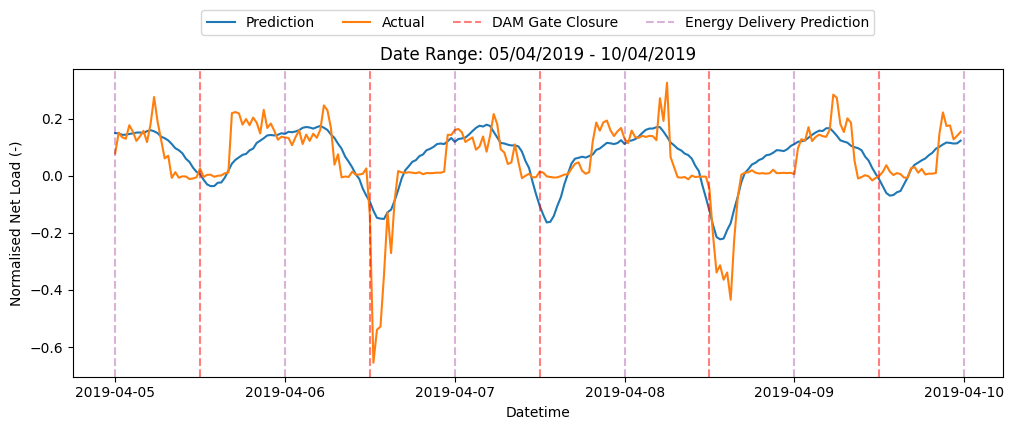

In [15]:
start_section = 0
end_section = 5

get_training_viz(start_section, end_section, df_input, X_train, y_train)

In [16]:
test_mse, test_mae = get_test_metrics(model, X_test, y_test)
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}") 

1/1 [==============================] - 0s 29ms/step
Test MSE: 0.02033661898497228
Test MAE: 0.0891815087345022


1/1 [==============================] - 0s 25ms/step


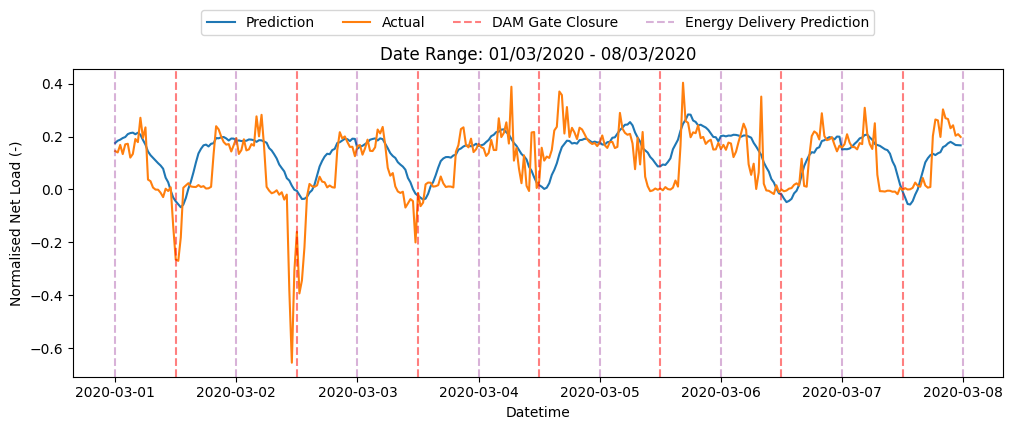

In [17]:
start_section = 7
end_section = 14

get_testing_viz(start_section, end_section, df_input, X_test, y_test)

# Train Outputs 

### Get MAE and MSE Values

In [ ]:
_, train_mse, train_mae = model.evaluate(X_train, y_train, verbose=1)
print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")

### Visualise

In [ ]:
# Parameters to change to better visualise the training results

# 1 = number of days i.e., 24 hours i.e., 48 time steps

start_section = 0
end_section = 5
diff = end_section-start_section

df_ts_train = df_input[n_input:n_split]

X_train_shift = X_train[24:]
y_train_shift = y_train[24:]

X_train_input = X_train_shift[::48]
y_train_input = y_train_shift[::48]


predictions = []

for i in X_train_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_train_input_24h = []

for i in y_train_input[start_section:end_section]:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_train_input_24h.append(i[24:])
    

plt.figure(figsize=(12,4))
plt.title(f"Date Range: {df_ts_train.index[start_section*48+48].strftime('%d/%m/%Y')} - {df_ts_train.index[end_section*48+48].strftime('%d/%m/%Y')}")

# We want to plot the predictions from 00:00 to 00:00 the next day.
plt.plot(df_ts_train.index[start_section*48+48: end_section*48+48], np.array(predictions).flatten(), label='Prediction')
plt.plot(df_ts_train.index[start_section*48+48: end_section*48+48], np.array(y_train_input_24h).flatten(), label = 'Actual')
plt.xlabel('Datetime')
plt.ylabel('Normalised Net Load (-)')


# Generate vertical lines for when we predict
xcoords_DAM = df_ts_train.index[start_section*48+72: (end_section)*48+72][::48]

for i, xc in enumerate(xcoords_DAM):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)



# Generate vertical lines for DAM closure
xcoords_pred = df_ts_train.index[start_section*48+48: (end_section+1)*48+48][::48]

for i, xc in enumerate(xcoords_pred):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3, label='Energy Delivery Prediction')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3)


plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)

# Test Outputs


### Get MAE and MSE Values

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_test_shift = X_test[24:]
y_test_shift = y_test[24:]

X_test_input = X_test_shift[::48]
y_test_input = y_test_shift[::48]

predictions = []

for i in X_test_input:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_test_input_24h = []

for i in y_test_input:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_test_input_24h.append(i[24:])

# Flatten the lists of lists into single lists
predictions_flat = [item for sublist in predictions for item in sublist]
y_test_flat = [item for sublist in y_test_input_24h for item in sublist]

# Calculate MSE
test_mse = mean_squared_error(y_test_flat, predictions_flat)

# Calculate MAE
test_mae = mean_absolute_error(y_test_flat, predictions_flat)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")


In [ ]:
# Parameters to change to better visualise the training results

# 1 = number of days i.e., 24 hours i.e., 48 time steps

start_section = 7
end_section = 14
diff = end_section-start_section

df_ts_test = df_input[n_input+n_split:]

X_test_shift = X_test[24:]
y_test_shift = y_test[24:]

X_test_input = X_test_shift[::48]
y_test_input = y_test_shift[::48]



predictions = []

for i in X_test_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_test_input_24h = []

for i in y_test_input[start_section:end_section]:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_test_input_24h.append(i[24:])
    

plt.figure(figsize=(12,4))
plt.title(f"Date Range: {df_ts_test.index[start_section*48+48].strftime('%d/%m/%Y')} - {df_ts_test.index[end_section*48+48].strftime('%d/%m/%Y')}")

# We want to plot the predictions from 00:00 to 00:00 the next day.
plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(predictions).flatten(), label='Prediction')
plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(y_test_input_24h).flatten(), label = 'Actual')
plt.xlabel('Datetime')
plt.ylabel('Normalised Net Load (-)')


# Generate vertical lines for when we predict
xcoords_DAM = df_ts_test.index[start_section*48+72: (end_section)*48+72][::48]

for i, xc in enumerate(xcoords_DAM):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)



# Generate vertical lines for DAM closure
xcoords_pred = df_ts_test.index[start_section*48+48: (end_section+1)*48+48][::48]

for i, xc in enumerate(xcoords_pred):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3, label='Energy Delivery Prediction')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3)


plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)

# Random Search - Hyperparameter Tuning

Hyperparameters to tune:
* \# of LSTM/GRU units
* \# of LSTM/GRU layers
* Dropout Rate
* Batch Size

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint
from kerastuner.tuners import RandomSearch

In [ ]:
# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(hp.Int('units_l1', min_value=64, max_value=256, step=64),
#                    input_shape=(X_train.shape[1], X_train.shape[2]),
#                    return_sequences=hp.Choice('return_seq', [True, False])))
#     model.add(BatchNormalization()) 
#     model.add(LeakyReLU(alpha=0.01))

#     for i in range(hp.Int('num_layers', 1, 3)):
#         model.add(LSTM(hp.Int(f'units_l{i+2}', min_value=64, max_value=256, step=64), return_sequences=False if i==hp.get('num_layers')-1 else True))
#         model.add(BatchNormalization()) 
#         model.add(LeakyReLU(alpha=0.01))

#     model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.3, step=0.1)))
#     model.add(Dense(y_train.shape[1]))

#     model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
#                   loss='mse',
#                   metrics=[MeanSquaredError(), MeanAbsoluteError()])

#     return model

def build_model(hp):
    model = Sequential()
    # Ensure the first LSTM layer always returns sequences
    model.add(LSTM(hp.Int('units_l1', min_value=64, max_value=256, step=64),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))  # Always return sequences for the first LSTM layer
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # Adjust subsequent LSTM layers based on their position
    for i in range(1, hp.Int('num_layers', 1, 3)):  # Start the range from 1 since we've already added the first LSTM layer
        model.add(LSTM(hp.Int(f'units_l{i+1}', min_value=64, max_value=256, step=64), 
                       return_sequences=False if i == hp.get('num_layers')-1 else True))
        model.add(BatchNormalization()) 
        model.add(LeakyReLU(alpha=0.01))

    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.3, step=0.1)))
    model.add(Dense(y_train.shape[1]))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mse',
                  metrics=[MeanSquaredError(), MeanAbsoluteError()])

    return model

In [ ]:
# Setting up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='house20'
)

# Display search space summary
tuner.search_space_summary()

In [ ]:
# Performing the hyperparameter search
tuner.search(X_train, y_train,
             epochs=10,
             batch_size=16,
             validation_split=0.1,
             callbacks=[ModelCheckpoint('model_{epoch}.keras', save_best_only=True)])


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first LSTM layer is {best_hps.get('units_first_layer')} and the second LSTM layer is {best_hps.get('units_second_layer')}.
The optimal dropout rate is {best_hps.get('dropout')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

In [ ]:
# Build the model with the best hyperparameters and train it on the data for 20 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16)

### Define the model building function

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()

    # model.add(LSTM(hp.Choice('num_lstm_units_first_layer', values=[32, 64, 128, 256]),
    #                input_shape=(X_train.shape[1], X_train.shape[2]),
    #                return_sequences=True if hp.Int('num_lstm_layers', 1, 3) > 1 else False))
    # model.add(BatchNormalization())
    # model.add(LeakyReLU(alpha=0.01))

    model.add(LSTM(hp.Choice('num_lstm_units_first_layer', values=[8,4]),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True if hp.Int('num_lstm_layers', 1, 3) > 1 else False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # num_lstm_layers = hp.Int('num_lstm_layers', 1, 3)
    # for i in range(num_lstm_layers - 1):
    #     model.add(LSTM(hp.Choice(f'num_lstm_units_layer_{i+2}', values=[32, 64, 128, 256]),
    #                    return_sequences=(i < num_lstm_layers - 2)))  # Only return sequences if not the last LSTM layer
    #     model.add(BatchNormalization())
    #     model.add(LeakyReLU(alpha=0.01))

    num_lstm_layers = hp.Int('num_lstm_layers', 1, 3)
    for i in range(num_lstm_layers - 1):
        model.add(LSTM(hp.Choice(f'num_lstm_units_layer_{i+2}', values=[4,2]),
                       return_sequences=(i < num_lstm_layers - 2)))  # Only return sequences if not the last LSTM layer
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.01))



    model.add(Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.2, step=0.1)))
    model.add(Dense(y_train.shape[1]))

    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=[MeanSquaredError(), MeanAbsoluteError()])

    return model

### Initiliase random search tuner

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Number of trials to run
    executions_per_trial=1,  # Number of models to build for each trial
    directory='keras_tuner_dir_LSTM_2',  # Directory to save logs and models
    project_name='lstm_tuning'
)

### Run the search

In [ ]:
tuner.search(X_train, y_train,
             epochs=10,
             validation_split=0.1,
             callbacks=[ModelCheckpoint('final_model.keras', save_best_only=True)])

### Summarise results

In [ ]:
# Display a summary of the search
tuner.results_summary()

# Retrieve the best model's hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("The best hyperparameters are:")
print(f"- Number of units in the first LSTM layer: {best_hps.get('num_lstm_units_first_layer')}")
for i in range(1, best_hps.get('num_lstm_layers')):
    print(f"- Number of units in LSTM layer {i+1}: {best_hps.get(f'num_lstm_units_layer_{i+2}')}")
print(f"- Dropout rate: {best_hps.get('dropout_rate')}")
print(f"- Number of LSTM layers: {best_hps.get('num_lstm_layers')}")

### Rebuild best model

In [ ]:
model = build_model(best_hps)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_test_shift = X_test[24:]
y_test_shift = y_test[24:]

X_test_input = X_test_shift[::48]
y_test_input = y_test_shift[::48]

predictions = []

for i in X_test_input:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_test_input_24h = []

for i in y_test_input:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_test_input_24h.append(i[24:])

# Flatten the lists of lists into single lists
predictions_flat = [item for sublist in predictions for item in sublist]
y_test_flat = [item for sublist in y_test_input_24h for item in sublist]

# Calculate MSE
test_mse = mean_squared_error(y_test_flat, predictions_flat)

# Calculate MAE
test_mae = mean_absolute_error(y_test_flat, predictions_flat)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

In [ ]:
# Parameters to change to better visualise the training results

# 1 = number of days i.e., 24 hours i.e., 48 time steps

start_section = 7
end_section = 14
diff = end_section-start_section

df_ts_test = df_input[n_input+n_split:]

X_test_shift = X_test[24:]
y_test_shift = y_test[24:]

X_test_input = X_test_shift[::48]
y_test_input = y_test_shift[::48]



predictions = []

for i in X_test_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_test_input_24h = []

for i in y_test_input[start_section:end_section]:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_test_input_24h.append(i[24:])
    

plt.figure(figsize=(12,4))
plt.title(f"Date Range: {df_ts_test.index[start_section*48+48].strftime('%d/%m/%Y')} - {df_ts_test.index[end_section*48+48].strftime('%d/%m/%Y')}")

# We want to plot the predictions from 00:00 to 00:00 the next day.
plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(predictions).flatten(), label='Prediction')
plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(y_test_input_24h).flatten(), label = 'Actual')
plt.xlabel('Datetime')
plt.ylabel('Normalised Net Load (-)')


# Generate vertical lines for when we predict
xcoords_DAM = df_ts_test.index[start_section*48+72: (end_section)*48+72][::48]

for i, xc in enumerate(xcoords_DAM):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)



# Generate vertical lines for DAM closure
xcoords_pred = df_ts_test.index[start_section*48+48: (end_section+1)*48+48][::48]

for i, xc in enumerate(xcoords_pred):
    if i == 0:  # First item gets the label
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3, label='Energy Delivery Prediction')
    else:  # Subsequent items do not
        plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3)


plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)

In [ ]:
import keras_tuner as kt
build_model(kt.HyperParameters())

In [ ]:
rtuner = kt.RandomSearch(hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    seed=12345,
    overwrite=True,
    directory="my_dir",
    project_name="diab")

In [ ]:
rtuner.search(X_train,
              y_train,
              epochs=10,
              validation_data=(X_test, y_test))

In [ ]:
tuned_model = rtuner.get_best_models(num_models=1)

In [ ]:
tuned_model.summary()

In [ ]:
rtuner.get_best_hyperparameters().get_config()['values']